In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
%matplotlib inline
colors = sns.color_palette('Set1', 9)
plt.rcParams["figure.figsize"] = (4,3)

In [2]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as gmm
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('Player_Data.csv')
ocols = [x for x in df.columns if x.startswith('o_')]
dcols = [x for x in df.columns if x.startswith('d_')]

# Get the columns to perform K-means on
Xo = df[ocols].values
Xd = df[dcols].values

# Normalize values to 0 mean and 1 standard deviation
Xo_norm = StandardScaler().fit_transform(Xo)
Xd_norm = StandardScaler().fit_transform(Xd)

In [3]:
from sklearn.metrics import silhouette_score, silhouette_samples

def elbow(k_max, X, title):
    f, ax1 = plt.subplots(1, 1)
    elbow = {}
    scores = {}
    for k in range(2,k_max):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        elbow[k] = kmeans.inertia_
        labels = kmeans.labels_
        scores[k] = silhouette_score(X, labels)
    sns.pointplot(x=list(elbow.keys()), y=list(elbow.values()),
                  color=colors[0], ax=ax1)
    ax1.set_title(title)
    ax1.set(xlabel='Clusters', ylabel='Sum of Squared Distances')
    ax2 = ax1.twinx()
    sns.pointplot(x=list(scores.keys()), y=list(scores.values()),
                  color=colors[1], ax=ax2)
    ax2.set(ylabel='Silhouette Score')
    ax2.grid(None)

    handles,labels = [],[]
    ax1.legend(handles=ax1.lines[::len(scores.keys())], labels=["Sum of Squares"],
              loc=1, bbox_to_anchor=(.995, 1))
    ax2.legend(handles=ax2.lines[::len(scores.keys())], labels=["Silhouette Score"],
              loc=1, bbox_to_anchor=(1, .92))

    

In [4]:
def aicBic(k_max, X, title):
    f, ax = plt.subplots(1, 1)
    aic = {}
    bic = {}
    scores = {}
    for k in range(2,k_max):
        gm = gmm(n_components=k, random_state=0).fit(X)
        aic[k] = gm.aic(X)
        bic[k] = gm.bic(X)
        labels = gm.predict(X)
        scores[k] = silhouette_score(X, labels)
    sns.pointplot(x=list(aic.keys()), y=list(aic.values()),
                  color=colors[0], ax=ax)
    sns.pointplot(x=list(bic.keys()), y=list(bic.values()),
                  color=colors[1], ax=ax)
    ax.set_title(title)
    ax.set(xlabel='Clusters', ylabel='IC Score')
    ax2 = ax.twinx()
    sns.pointplot(x=list(scores.keys()), y=list(scores.values()),
                  color=colors[2], ax=ax2)
    ax2.set(ylabel='Silhouette Score')
    ax2.grid(None)
    
    ax.legend(handles=ax.lines[::len(aic.keys())+1],
              labels=["AIC","BIC"],
              loc=9, bbox_to_anchor=(.272, 1))
    ax2.legend(handles=ax2.lines[::len(scores.keys())], labels=["Silhouette Score"],
              loc=9, bbox_to_anchor=(.4, .83))

In [5]:
import matplotlib.cm as cm

def sil_scores(n, X, title, algo='Kmeans'):
    scores = {}
    for k in range(2, n):
        if algo=='Kmeans':
            kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
            labels = kmeans.labels_
        elif algo=='GMM':
            gm = gmm(n_components=k, random_state=0).fit(X)
            labels = gm.predict(X)
        scores[k] = silhouette_score(X, labels)
    f, ax = plt.subplots(1, 1)
    sns.pointplot(x=list(scores.keys()), y=list(scores.values()),
                  color=colors[0], ax=ax)
    ax.set_title(title)
    ax.set(xlabel='Clusters', ylabel='Silhouette Score')

In [6]:
def silhouette(k, X, title, algo='Kmeans'):
    if algo=='Kmeans':
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        labels = kmeans.labels_
        centers = kmeans.cluster_centers_
    elif algo == 'GMM':
        gm = gmm(n_components=k, random_state=0).fit(X)
        labels = gm.predict(X)
        centers = gm.means_
    sil_av = silhouette_score(X, labels)
    sil_samp = silhouette_samples(X, labels)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    y_lower = 10
    c_dict = {}
    for i in range(k):
        sil_vals = sil_samp[labels == i]
        sil_vals.sort()
        clust_size = sil_vals.shape[0]
        y_upper = y_lower + clust_size
        color = colors[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                         0, sil_vals, facecolor=color,
                         edgecolor=color, alpha=.78)
        ax1.text(-0.05, y_lower + 0.5 * clust_size, str(i))
        y_lower = y_upper + 10
        c_dict[i] = colors[i]
    ax1.axvline(x=sil_av, color="red", linestyle="--")
    ax1.set_title('Silhouette Plot')
    ax1.set(xlabel='Silhouette Coefficient Values', ylabel='Cluster Label')
    ax1.set_yticks([])

    colors2 = [colors[x] for x in labels]
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors2, edgecolor='k')
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
        
    ax2.set_title("Clustered Data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    plt.suptitle((title),
                 fontsize=13, fontweight='bold')

In [7]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA as ICA

def transformDF(X, trans, title='', n=0):
    
    if trans == 'PCA':
        f, ax = plt.subplots(1, 1)
        n = len(X[0])
        pca = PCA(n_components=n, random_state=0)
        cols = ['PC'+str(x+1) for x in range(n)]
        dft = pd.DataFrame(pca.fit_transform(X), columns=cols)

        sns.pointplot(y=pca.explained_variance_ratio_,
                    x=[x for x in range(1,n+1)], color=colors[0],
                      ax=ax)
        sns.pointplot(y=np.cumsum(pca.explained_variance_ratio_),
                      x=[x for x in range(1,n+1)], color=colors[1],
                      ax=ax)

        ax.legend(
            handles=ax.lines[::len(pca.explained_variance_ratio_)+1],
                  labels=["Variance Explained","Cumulative Variance Explained"])
        ax.set_title(title)
        ax.set_xlabel("Components")
        ax.set_ylabel("Variance Explained")
        
    elif trans == 'ICA':
        f, ax = plt.subplots(1, 1)
        ica = ICA(n_components=n, random_state=0)
        cols = ['IC'+str(x+1) for x in range(n)]
        dft = pd.DataFrame(ica.fit_transform(X), columns=cols)
        dft = dft[dft.kurt(axis=0).abs().sort_values(ascending=False).index]
        sns.barplot(x=dft.kurt(axis=0).abs().sort_values(ascending=False), y=dft.columns,
                    color=colors[0], ax=ax)
        dft = dft[dft.kurt(axis=0).abs().sort_values(ascending=False).iloc[:-int(n/2)].index]
        ax.set_title(title)
        ax.set_xlabel("Kurtosis")
        ax.set_ylabel("Components")
        
    elif trans == 'RCA':
        rca = RP(n_components=n, random_state=0)
        cols = ['RC'+str(x+1) for x in range(n)]
        dft = pd.DataFrame(rca.fit_transform(X), columns=cols)
        
    elif trans == 'FA':
        fa = FA(n_clusters=n)
        cols = ['FA'+str(x+1) for x in range(n)]
        dft = pd.DataFrame(fa.fit_transform(X), columns=cols)
        
    return dft

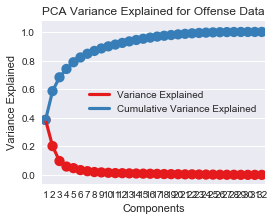

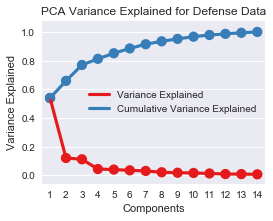

In [8]:
dfpcao = transformDF(Xo_norm, 'PCA', 'PCA Variance Explained for Offense Data')
dfpcad = transformDF(Xd_norm, 'PCA', 'PCA Variance Explained for Defense Data')

In [9]:
from sklearn.decomposition import FastICA as ICA

def elbowICA(X, title):
    elbow_all = {}
    elbow_top = {}
    n = len(X[0])
    f, ax = plt.subplots(1, 1)
    
    for k in range(2,n+1):
        df = pd.DataFrame(ICA(n_components=k, random_state=0).fit_transform(X))
        dfkurt = df.kurt(axis=0)
        elbow_all[k] = dfkurt.abs().mean()
        elbow_top[k] = dfkurt.abs().sort_values().iloc[int(k/2):].mean()
        
    sns.pointplot(x=list(elbow_all.keys()), y=list(elbow_all.values()),
                  color=colors[0], ax=ax)
    sns.pointplot(x=list(elbow_top.keys()), y=list(elbow_top.values()),
                  color=colors[1], ax=ax)
    ax.legend(
            handles=ax.lines[::len(elbow_all.keys())+1],
                  labels=["Kurtosis for All Components", "Kurtosis for Top 50% of Components"])
    ax.set_title(title)
    ax.set_xlabel("Number of Components")
    ax.set_ylabel("Kurtosis")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


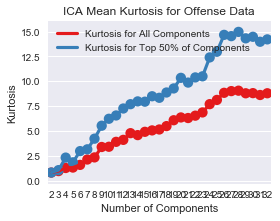

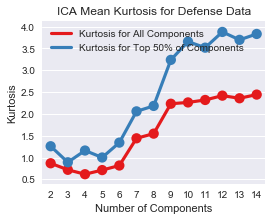

In [10]:
elbowICA(Xo_norm, 'ICA Mean Kurtosis for Offense Data')
elbowICA(Xd_norm, 'ICA Mean Kurtosis for Defense Data')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


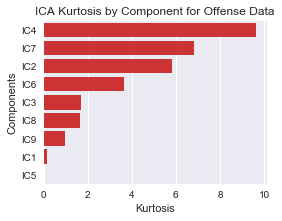

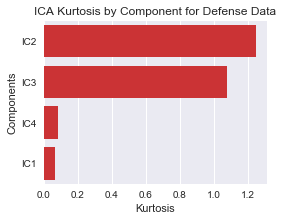

In [11]:
dficao = transformDF(Xo_norm, 'ICA', 'ICA Kurtosis by Component for Offense Data', 9)
dficad = transformDF(Xd_norm, 'ICA', 'ICA Kurtosis by Component for Defense Data', 4)

In [12]:
from sklearn.random_projection import GaussianRandomProjection as RP

def reconstructError(obj, X):
    if 'FeatureAgglomeration' in str(type(obj)):
        x_trans = obj.fit_transform(X)
        X_project = obj.inverse_transform(x_trans)
    elif 'GaussianRandomProjection' in str(type(obj)):
        X_trans = obj.fit_transform(X)
        mean = X.mean(axis=0)
        X_project = np.dot(X_trans, obj.components_) + mean
    return ((X - X_project) ** 2).mean()

def elbowRCA(X, title):
    df = pd.DataFrame()
    n = len(X[0])
    f, ax = plt.subplots(1, 1)
    for s in range(30):
        for k in range(2,n+1):
            df = df.append({'Reconstruction Error':reconstructError(RP(n_components=k,
                                                                       random_state=s), X),
                            'Components': int(k)}, ignore_index=True)
    df['Components'] = df['Components'].astype(int)
    sns.pointplot(x='Components', y='Reconstruction Error', data=df, scale=.75, markers='.',
                  color=colors[0], ax=ax)
    ax.set_title(title)

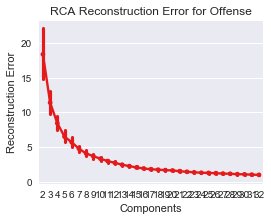

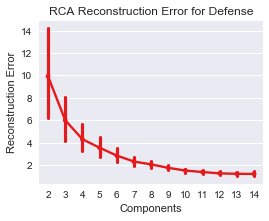

In [13]:
elbowRCA(Xo_norm, 'RCA Reconstruction Error for Offense')
elbowRCA(Xd_norm, 'RCA Reconstruction Error for Defense')

In [14]:
dfrcao = transformDF(Xo_norm, 'RCA', n=6)
dfrcad = transformDF(Xd_norm, 'RCA', n=4)

In [15]:
from sklearn.cluster import FeatureAgglomeration as FA

def elbowFA(X, title):
    df = pd.DataFrame()
    n = len(X[0])
    f, ax = plt.subplots(1, 1)
    for k in range(1,n+1):
        df = df.append({'Reconstruction Error':reconstructError(FA(n_clusters=k), X),
                        'Clusters': int(k)}, ignore_index=True)
    df['Clusters'] = df['Clusters'].astype(int)
    sns.pointplot(x='Clusters', y='Reconstruction Error', data=df,
                  color=colors[0], ax=ax)
    ax.set_title(title)

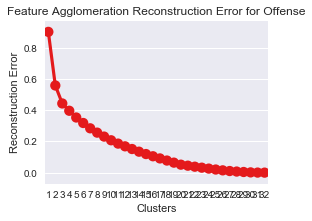

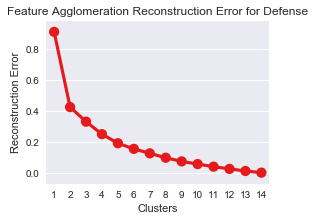

In [16]:
elbowFA(Xo_norm, 'Feature Agglomeration Reconstruction Error for Offense')
elbowFA(Xd_norm, 'Feature Agglomeration Reconstruction Error for Defense')

In [17]:
dffao = transformDF(Xo_norm, 'FA', n=5)
dffad = transformDF(Xd_norm, 'FA', n=5)

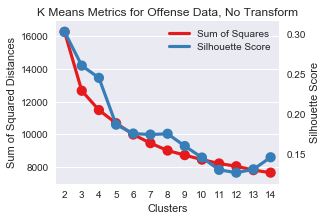

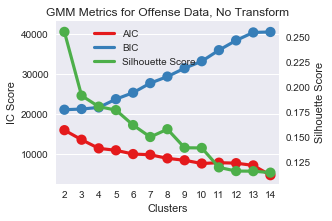

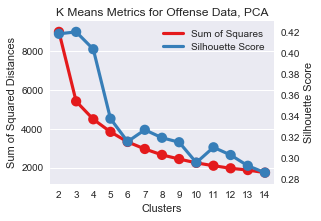

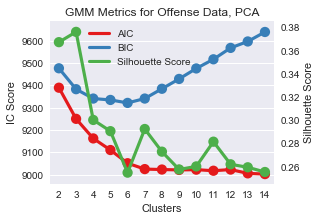

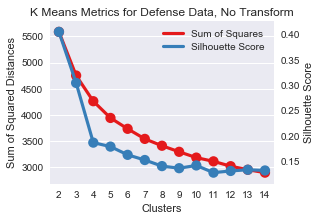

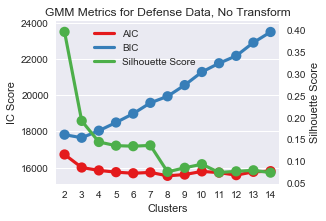

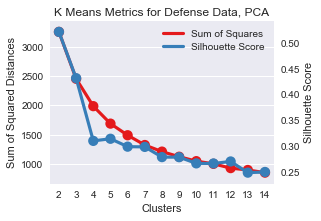

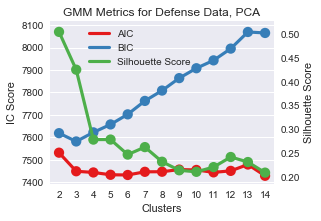

In [18]:
data_dict = {'Offense':{'No Transform':Xo_norm,
                        'PCA':dfpcao[['PC1', 'PC2', 'PC3']].values,
#                         'ICA':dficao.values,
#                         'RCA':dfrcao.values,
#                         'FA':dfrcao.values
                       },
             'Defense':{'No Transform':Xd_norm,
                        'PCA':dfpcad[['PC1', 'PC2', 'PC3']].values,
#                         'ICA':dficad.values,
#                         'RCA':dfrcad.values,
#                         'FA':dffad.values
                       }
            }

for side, dict1 in data_dict.items():
    for transform, d in dict1.items():
        elbow(15, d, 'K Means Metrics for {0} Data, {1}'.format(side, transform))
        aicBic(15, d, 'GMM Metrics for {0} Data, {1}'.format(side, transform))

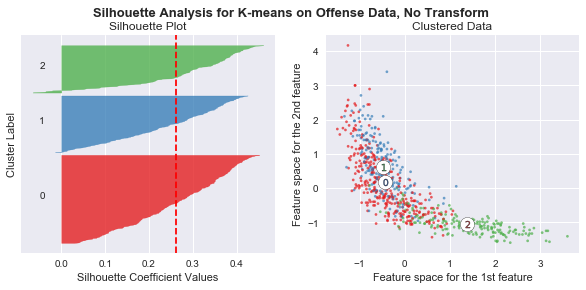

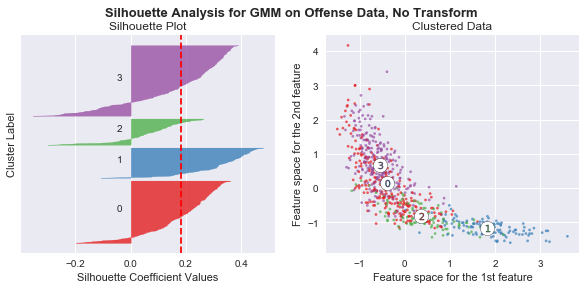

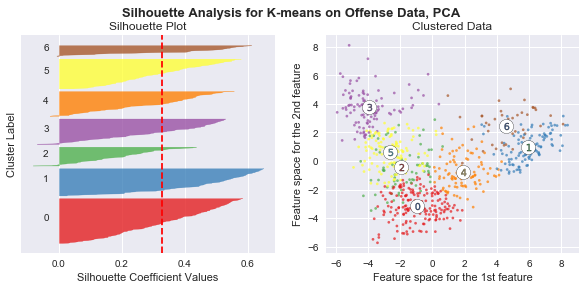

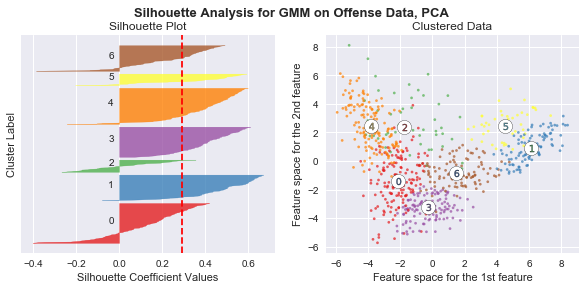

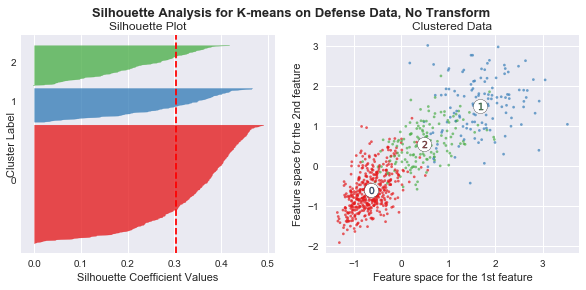

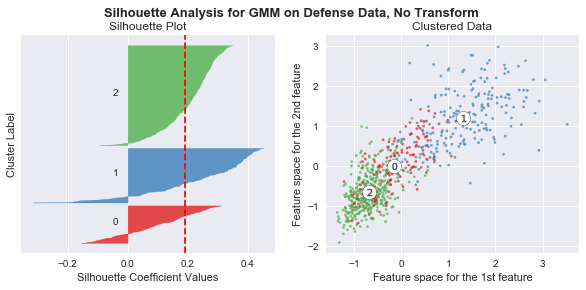

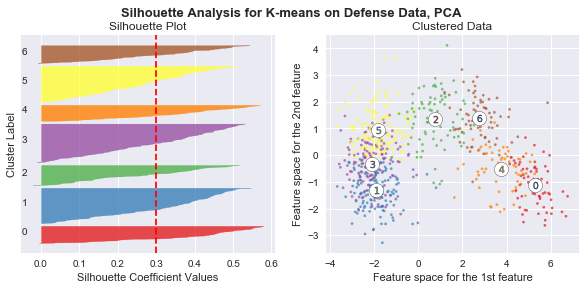

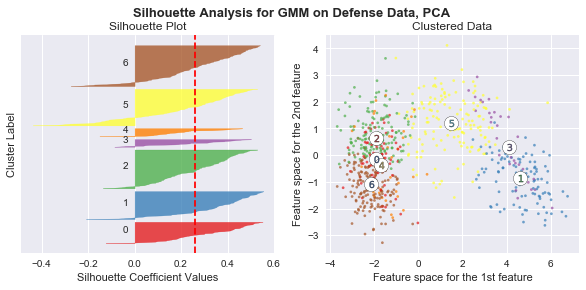

In [19]:
data_dict = {'Offense':{'No Transform':[Xo_norm, 3, 4],
                        'PCA':[dfpcao[['PC1', 'PC2', 'PC3']].values, 7, 7],
#                         'ICA':[dficao.values, 6, 5],
#                         'RCA':[dfrcao.values, 4, 4],
#                         'FA':[dffao.values, 4, 4]
                       },
             'Defense':{'No Transform':[Xd_norm, 3, 3],
                        'PCA':[dfpcad[['PC1', 'PC2', 'PC3']].values, 7, 7],
#                         'ICA':[dficad.values, 4, 8],
#                         'RCA':[dfrcad.values, 7, 7],
#                         'FA':[dffad.values, 5, 5]
                       }
            }

for side, dict1 in data_dict.items():
    for transform, d in dict1.items():
        silhouette(d[1], d[0],
                   'Silhouette Analysis for K-means on {0} Data, {1}'.format(side, transform),
                   'Kmeans')
        silhouette(d[2], d[0],
                   'Silhouette Analysis for GMM on {0} Data, {1}'.format(side, transform),
                   'GMM')

In [20]:
def getClusters(df, df_orig, n_clusters, n_comp, cols, name, algo='Kmeans'):
    X = df.iloc[:, 0:n_comp].values
    
    if algo == 'Kmeans':
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
        df['Cluster'] = kmeans.labels_
        df_orig[name] = kmeans.labels_
        centers = kmeans.cluster_centers_
    elif algo == 'GMM':
        gm = gmm(n_components=n_clusters, random_state=0).fit(X)
        df['Cluster'] = gm.predict(X)
        df_orig[name] = gm.predict(X)
        centers = gm.means_
    
    df_orig['Dist'] = 0
    for i in range(n_comp):
        df_orig['Dist'] = df_orig['Dist'] + df.apply(lambda x:
                                                        (x[i] - centers[int(x['Cluster'])][i])**2,
                                                        axis=1)
    df.drop(['Cluster'], inplace=True, axis=1)
    print('-------{}-------'.format(algo))
    print(df_orig.groupby(name).count()['Dist'])
    print(df_orig.groupby([name, 'P']).count()['Dist'])
    print(df_orig.groupby(name).mean()['Dist'])
    display(df_orig.groupby(name).mean()[cols[:int(len(cols)/2)]])
    display(df_orig.groupby(name).mean()[cols[int(len(cols)/2):]])
    print(df_orig.loc[df_orig.sort_values('Dist',
                                            ascending=False).groupby(name).head(7).index,
                 ['DISPLAY_FIRST_LAST',
                  'season', name, 'Dist']
                ].sort_values(name))

In [21]:
getClusters(dfpcao, df, 8, 3, ocols, 'PCA_Cluster_O', 'Kmeans')

-------Kmeans-------
PCA_Cluster_O
0     52
1     97
2    114
3    111
4     82
5     42
6    108
7    114
Name: Dist, dtype: int64
PCA_Cluster_O  P  
0              F       16
               G       22
               G-F     14
1              C       11
               F       65
               F-C     15
               G        1
               G-F      5
2              F       78
               F-C      1
               G       20
               G-F     15
3              C       60
               F       29
               F-C     21
               G-F      1
4              F        3
               G       79
5              C       17
               F       13
               F-C     12
6              F       18
               G       72
               G-F     18
7              F        5
               G      104
               G-F      5
Name: Dist, dtype: int64
PCA_Cluster_O
0    5.881827
1    3.919743
2    2.381327
3    4.020832
4    3.826488
5    5.542379
6    3.325435
7    2.988

,o_OREB_CHANCES,o_AVG_OREB_DIST,o_PULL_UP_FG3A,o_AVG_SEC_PER_TOUCH,o_AVG_DRIB_PER_TOUCH,o_ELBOW_TOUCHES,o_POST_TOUCHES,o_PAINT_TOUCHES,o_TOUCHES,o_PASSES_MADE,o_PASSES_RECEIVED,o_CATCH_SHOOT_FG3A,o_DRIVES,o_Misc_Poss,o_OffRebound_Poss,o_OffScreen_Poss
PCA_Cluster_O,,,,,,,,,,,,,,,,
0,0.090073,10.711538,0.052416,3.494231,2.708654,0.047524,0.064342,0.057037,1.776538,1.104621,1.387003,0.090614,0.247273,0.028043,0.014184,0.056298
1,0.132874,7.335052,0.009663,1.942784,0.910619,0.073816,0.082901,0.118410,1.732969,1.243216,1.060217,0.098313,0.110262,0.023727,0.026819,0.016045
2,0.094055,9.829825,0.011799,1.891930,0.965088,0.029010,0.015719,0.063679,1.349643,0.988193,0.848000,0.118850,0.090711,0.016491,0.014706,0.016944
3,0.237120,5.631532,0.000925,1.661081,0.508288,0.148484,0.093058,0.275909,1.615842,1.194851,0.865496,0.007803,0.032355,0.036359,0.061002,0.002077
4,0.091640,12.606098,0.073109,5.081098,4.789146,0.022815,0.014372,0.035126,2.494769,1.817817,2.147886,0.063343,0.398593,0.031132,0.008895,0.020268
5,0.164838,6.538095,0.004478,1.939762,0.723333,0.150255,0.248134,0.192801,1.969073,1.334545,1.277415,0.063995,0.083593,0.034874,0.048184,0.020430
6,0.062186,13.389815,0.037224,2.400926,1.617130,0.024087,0.012374,0.032739,1.368005,0.902268,1.041738,0.142263,0.138973,0.017326,0.007126,0.056692
7,0.081376,12.537719,0.038294,4.169211,3.754825,0.020680,0.010618,0.035213,2.003658,1.505872,1.661839,0.080454,0.258402,0.021727,0.006973,0.015759


,o_Cut_Poss,o_Handoff_Poss,o_Spotup_Poss,o_Postup_Poss,o_PRRollMan_Poss,o_PRBallHandler_Poss,o_Isolation_Poss,o_Transition_Poss,o_RA,o_Non_RA,o_Mid,o_Above_Break,o_Corner,o_CATCH_SHOOT_FG2A,o_PULL_UP_FG2A,o_DRIVE_PASS_PCT
PCA_Cluster_O,,,,,,,,,,,,,,,,
0,0.023125,0.034485,0.082454,0.037733,0.009730,0.154895,0.081428,0.088491,0.115309,0.070102,0.155386,0.117930,0.024309,0.028629,0.149607,0.277486
1,0.036770,0.008740,0.106566,0.042457,0.050892,0.017708,0.026493,0.057508,0.119327,0.054953,0.079179,0.081139,0.026478,0.039186,0.049262,0.229285
2,0.022001,0.013135,0.106316,0.007514,0.012239,0.018496,0.008646,0.055362,0.077882,0.024785,0.037642,0.082756,0.047473,0.014045,0.028051,0.305599
3,0.083246,0.001271,0.026322,0.048928,0.075539,0.001172,0.011715,0.031122,0.176986,0.063404,0.043071,0.005360,0.002932,0.037748,0.011423,0.202949
4,0.012752,0.030716,0.067299,0.009959,0.001308,0.237063,0.070806,0.090840,0.135693,0.068993,0.106089,0.118013,0.017902,0.009012,0.119201,0.352315
5,0.048159,0.005132,0.086892,0.145249,0.109845,0.005367,0.044552,0.042551,0.146478,0.100657,0.152176,0.060512,0.007789,0.102455,0.064259,0.167817
6,0.014890,0.039708,0.111608,0.006035,0.004167,0.061886,0.021348,0.068896,0.066868,0.035538,0.076170,0.135187,0.044139,0.020317,0.067572,0.313582
7,0.013234,0.023531,0.080608,0.005607,0.001704,0.121142,0.031494,0.061508,0.095937,0.047872,0.073313,0.090340,0.027606,0.008740,0.078886,0.360018


          DISPLAY_FIRST_LAST  season  PCA_Cluster_O       Dist
42     Giannis Antetokounmpo    2017              0  20.804154
18     Giannis Antetokounmpo    2016              0  20.142099
75             DeMar DeRozan    2016              0  14.796519
33           Harrison Barnes    2016              0  12.651971
91           Carmelo Anthony    2016              0  14.319743
44              LeBron James    2015              0  13.878381
197              Dwyane Wade    2015              0  13.084829
21     Giannis Antetokounmpo    2015              1  11.023133
337            Blake Griffin    2017              1   9.771416
113         DeMarcus Cousins    2016              1   8.667258
388             Myles Turner    2017              1   8.462020
364            Dirk Nowitzki    2017              1  13.965527
381  Rondae Hollis-Jefferson    2017              1   9.904448
442              Brook Lopez    2017              1   8.305562
509           Andre Iguodala    2017              2   6

In [93]:
getClusters(dfpcad, df, 8, 3, dcols, 'PCA_Cluster_D', 'Kmeans')

-------Kmeans-------
PCA_Cluster_D
0     68
1    138
2     64
3    129
4    113
5     71
6     78
7     59
Name: Dist, dtype: int64
PCA_Cluster_D  P  
0              C       45
               F        7
               F-C     16
1              F       53
               G       72
               G-F     13
2              C       31
               F       19
               F-C     14
3              F        9
               G      110
               G-F     10
4              F       28
               G       65
               G-F     20
5              C       10
               F       44
               F-C     16
               G-F      1
6              C        2
               F       63
               F-C      3
               G        1
               G-F      9
7              F        4
               G       50
               G-F      5
Name: Dist, dtype: int64
PCA_Cluster_D
0    1.737312
1    1.805600
2    1.663839
3    1.059037
4    1.584808
5    2.068373
6    2.067596
7    1.865

,d_DEF_RIM_FGA,d_DREB_CHANCES,d_AVG_DREB_DIST,d_OffScreen_Poss,d_Handoff_Poss,d_Spotup_Poss,d_Postup_Poss
PCA_Cluster_D,,,,,,,
0,0.190208,0.365585,4.538235,0.007682,0.003276,0.065214,0.057710
1,0.075857,0.203714,7.427536,0.034235,0.028159,0.108571,0.020573
2,0.164219,0.359128,4.564062,0.008099,0.004199,0.063758,0.042503
3,0.058546,0.172245,8.866667,0.031481,0.028700,0.074984,0.019328
4,0.065373,0.190186,7.658407,0.028917,0.024315,0.080382,0.015973
5,0.135454,0.303682,5.223944,0.015688,0.008300,0.100474,0.042504
6,0.108153,0.275635,5.637179,0.019720,0.011919,0.098735,0.029474
7,0.064843,0.189047,8.574576,0.030855,0.030737,0.076617,0.024043


,d_PRRollMan_Poss,d_PRBallHandler_Poss,d_Isolation_Poss,d_6_10,d_10_15,d_15_3PT,d_3PT
PCA_Cluster_D,,,,,,,
0,0.037692,0.003125,0.037317,0.069375,0.039784,0.079379,0.065492
1,0.008832,0.102872,0.031905,0.030145,0.027122,0.058091,0.134462
2,0.034393,0.004731,0.029990,0.054666,0.028557,0.060345,0.074488
3,0.006960,0.127316,0.023990,0.027706,0.029031,0.057456,0.111395
4,0.006237,0.077070,0.021594,0.024020,0.021224,0.045183,0.112290
5,0.031823,0.018063,0.050106,0.051224,0.030795,0.071536,0.112467
6,0.019852,0.033811,0.037085,0.037877,0.025135,0.053541,0.120829
7,0.008640,0.159454,0.028629,0.035018,0.037969,0.074425,0.114218


           DISPLAY_FIRST_LAST  season  PCA_Cluster_D       Dist
660            Timofey Mozgov    2015              0   6.644916
144              Steven Adams    2016              0   4.480767
312              Steven Adams    2015              0   3.667417
272             Mason Plumlee    2015              0   3.672489
212               Brook Lopez    2016              0   5.953592
632              Jusuf Nurkic    2016              0   4.632420
163          Tristan Thompson    2016              0   4.141785
146            Andre Roberson    2016              1   5.762906
157    Michael Kidd-Gilchrist    2016              1  10.401128
137             Jabari Parker    2015              1   7.916059
392              Jrue Holiday    2015              1   5.876069
452             Jabari Parker    2016              1   7.338282
519         Richard Jefferson    2016              1   6.925799
87             Victor Oladipo    2017              1   6.378899
506           Markieff Morris    2015   

In [95]:
# Re-order groups, smallest to largest
offense_map = {7:0, 4:1, 6:2, 2:3, 0:4, 1:5, 5:6, 3:7}
# defense_map = {1:0, 5:1, 3:2, 2:3, 6:4, 4:5, 0:6}
defense_map = {7:0, 3:1, 4:2, 1:3, 6:4, 5:5, 2:6, 0:7}

df['Ordered_O'] = df['PCA_Cluster_O'].map(offense_map)
df['Ordered_D'] = df['PCA_Cluster_D'].map(defense_map)

In [96]:
pd.crosstab(df['Ordered_O'], df['Ordered_D'])

Ordered_D,0,1,2,3,4,5,6,7
Ordered_O,,,,,,,,
0,27,46,20,17,4,0,0,0
1,16,33,9,22,2,0,0,0
2,4,36,31,33,3,1,0,0
3,7,10,19,44,20,13,0,1
4,4,3,24,13,8,0,0,0
5,1,1,9,9,30,32,11,4
6,0,0,0,0,4,9,14,15
7,0,0,1,0,7,16,39,48


In [98]:
df.loc[(df['Ordered_O'] == 1) & (df['Ordered_D'] == 3), ['DISPLAY_FIRST_LAST', 'season']]

,DISPLAY_FIRST_LAST,season
0,James Harden,2015
7,James Harden,2016
37,Kemba Walker,2016
46,Ben Simmons,2017
88,James Harden,2017
134,Elfrid Payton,2016
179,Mike Conley,2016
225,Jrue Holiday,2016
251,Elfrid Payton,2015
260,Deron Williams,2015


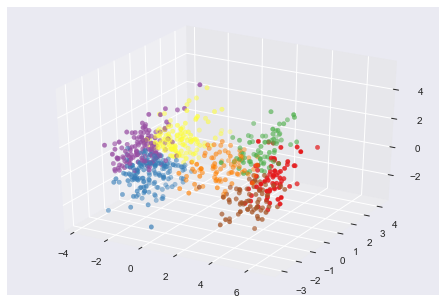

In [29]:
from mpl_toolkits.mplot3d import Axes3D

def plot3D(X, k):
    fig = plt.figure()
    ax = Axes3D(fig)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    labels = kmeans.labels_
    colors2 = [colors[x] for x in labels]
    ax.scatter(X[:,0], X[:,1], X[:,2], c = colors2)
    
plot3D(dfpcad[['PC1', 'PC2', 'PC3']].values, 7)

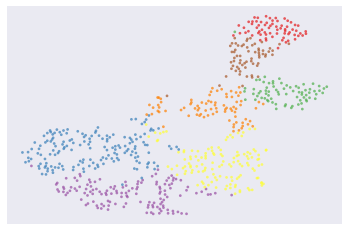

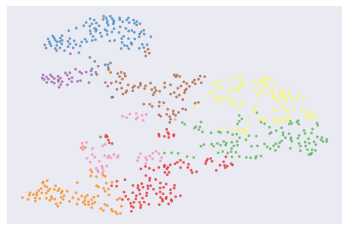

In [30]:
from sklearn.manifold import TSNE

def plotTSNE(X, labels):
    xembed = TSNE().fit_transform(X)
    f, ax = plt.subplots(1,1)
    colors2 = [colors[x] for x in labels]
    ax.scatter(xembed[:,0], xembed[:,1], marker='.', s=30, lw=0, alpha=.7, edgecolor='k',c=colors2)
    ax.set_yticks([])
    ax.set_xticks([])

plotTSNE(dfpcad[['PC1', 'PC2', 'PC3']].values, df['PCA_Cluster_D'].values)
plotTSNE(dfpcao[['PC1', 'PC2', 'PC3']].values, df['PCA_Cluster_O'].values)

In [37]:
dfreb = pd.read_csv('Rebound_Features.csv')

# Get arrays
Xreb = dfreb.values[:,:-1]
yreb = dfreb.values[:,-1]

# Normalize values to 0 mean and 1 standard deviation
Xreb_norm = StandardScaler().fit_transform(Xreb)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


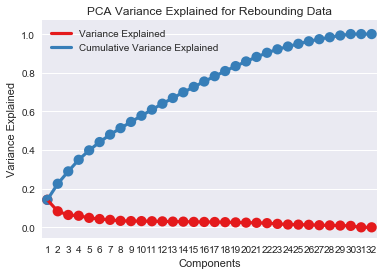

In [55]:
rebpca = transformDF(Xreb_norm, 'PCA', 'PCA Variance Explained for Rebounding Data')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


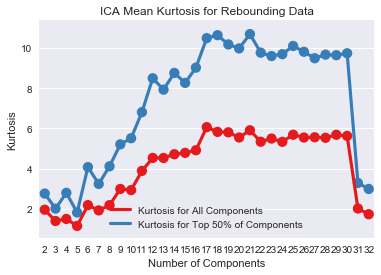

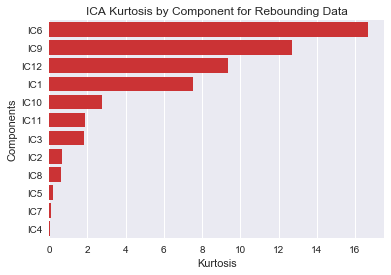

In [57]:
elbowICA(Xreb_norm, 'ICA Mean Kurtosis for Rebounding Data')
rebica = transformDF(Xreb_norm, 'ICA', 'ICA Kurtosis by Component for Rebounding Data', 12)

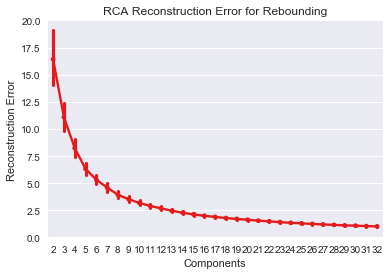

In [63]:
elbowRCA(Xreb_norm, 'RCA Reconstruction Error for Rebounding')
rebrca = transformDF(Xreb_norm, 'RCA', n=5)

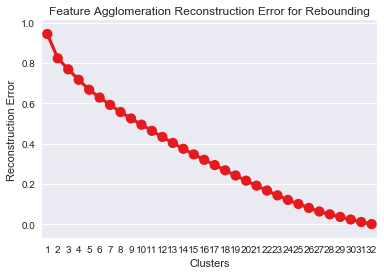

In [66]:
elbowFA(Xreb_norm, 'Feature Agglomeration Reconstruction Error for Rebounding')
rebfa = transformDF(Xreb_norm, 'FA', n=5)

No Transform 1
No Transform 2
No Transform 3
No Transform 4
No Transform 5
PCA 1
PCA 2
PCA 3
PCA 4
PCA 5
ICA 1
ICA 2
ICA 3
ICA 4
ICA 5
RCA 1
RCA 2
RCA 3
RCA 4
RCA 5
FA 1
FA 2
FA 3
FA 4
FA 5


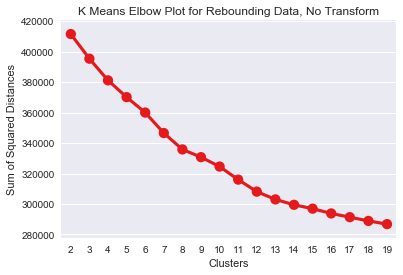

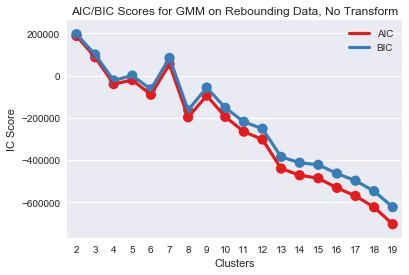

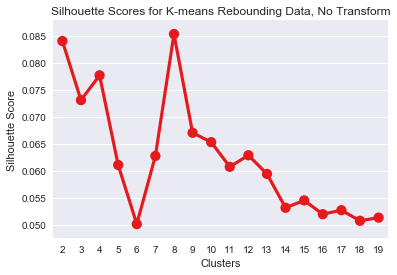

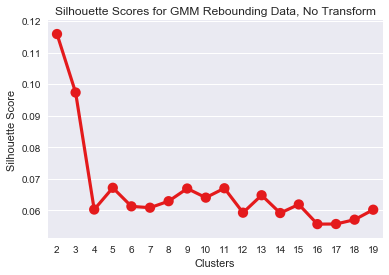

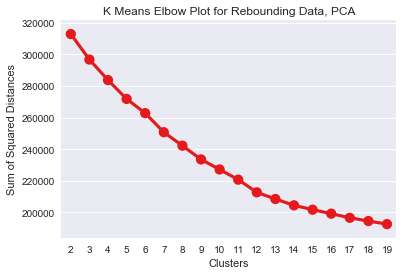

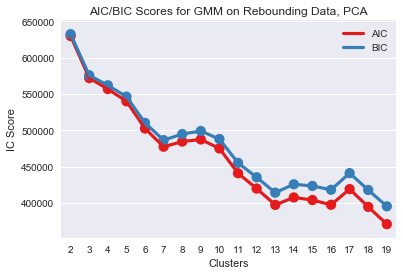

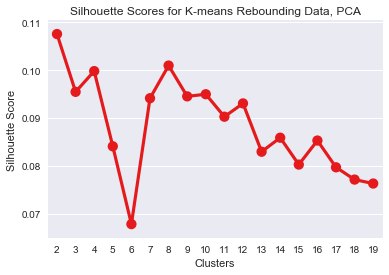

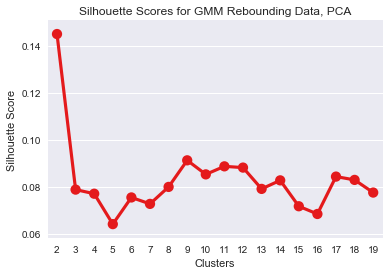

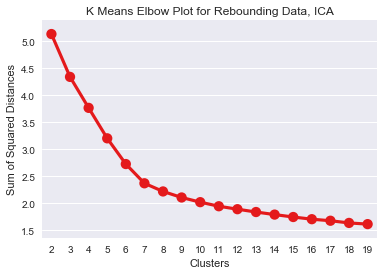

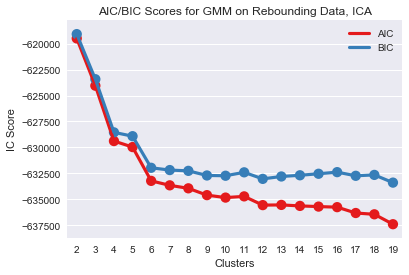

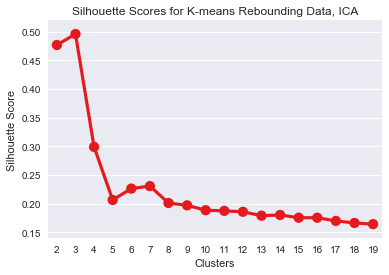

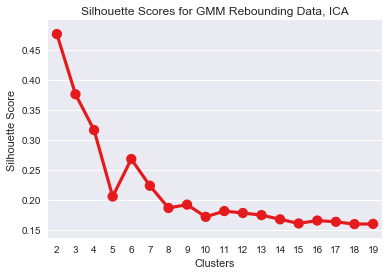

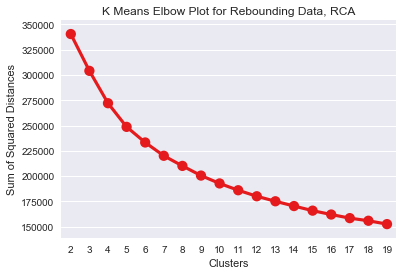

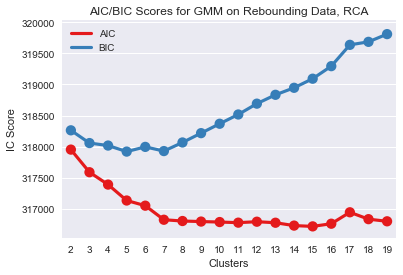

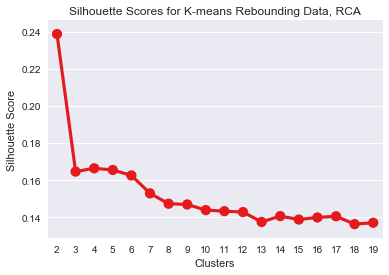

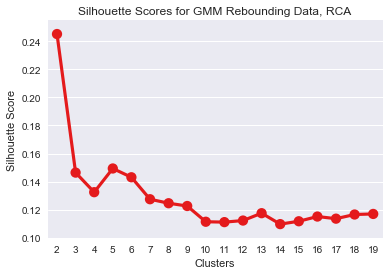

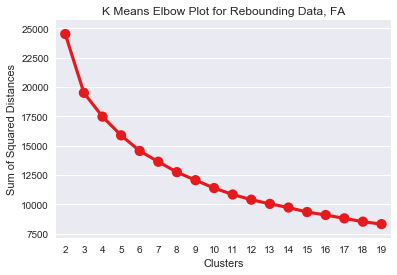

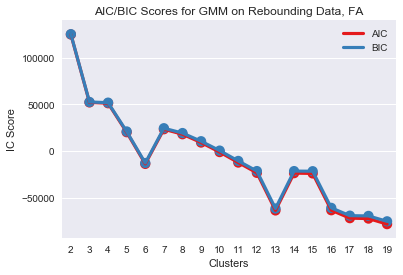

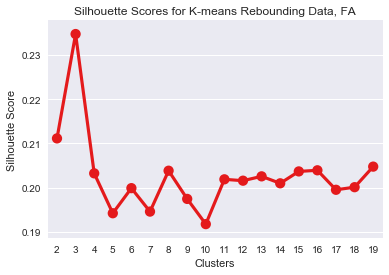

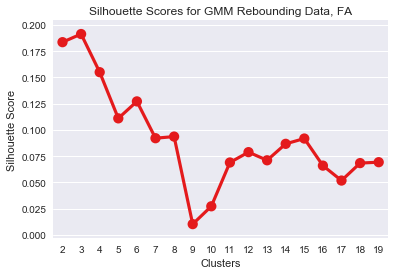

In [70]:
data_reb_dict = {'Rebounding': {'No Transform':Xreb_norm,
                                'PCA':rebpca.values[:,:17],
                                'ICA':rebica.values,
                                'RCA':rebrca.values,
                                'FA':rebfa.values
                           }
            }

for side, dict1 in data_reb_dict.items():
    for transform, d in dict1.items():
        print(transform + ' 1')
        elbow(20, d, 'K Means Elbow Plot for {0} Data, {1}'.format(side, transform))
        print(transform + ' 2')
        aicBic(20, d, 'AIC/BIC Scores for GMM on {0} Data, {1}'.format(side, transform))
        print(transform + ' 3')
        sil_scores(20, d, 'Silhouette Scores for K-means {0} Data, {1}'.format(side, transform),
                   'Kmeans')
        print(transform + ' 4')
        sil_scores(20, d, 'Silhouette Scores for GMM {0} Data, {1}'.format(side, transform),
                   'GMM')
        print(transform + ' 5')

No Transform 1
No Transform 2
PCA 1
PCA 2
ICA 1
ICA 2
RCA 1
RCA 2
FA 1
FA 2


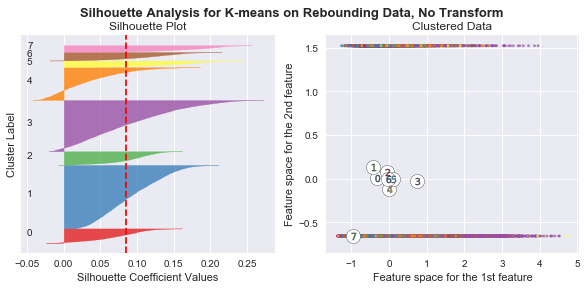

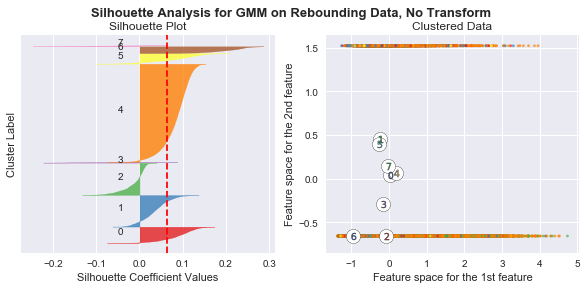

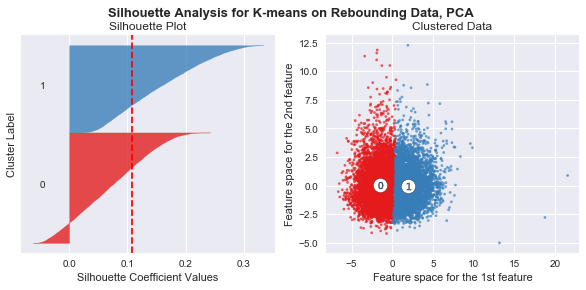

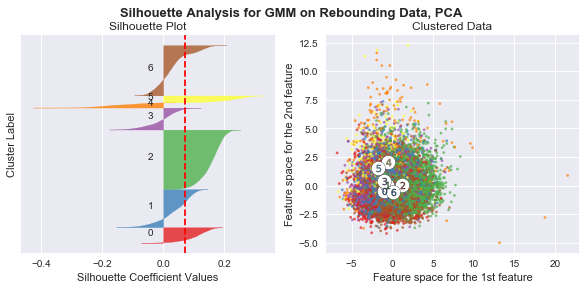

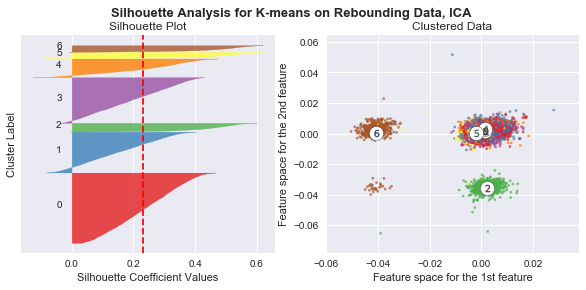

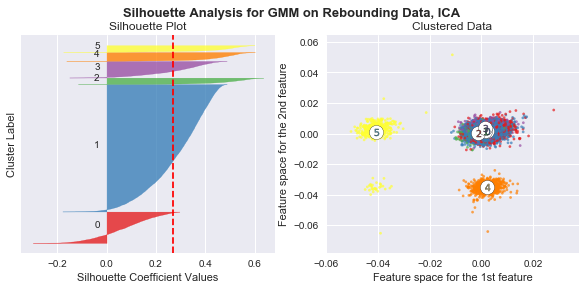

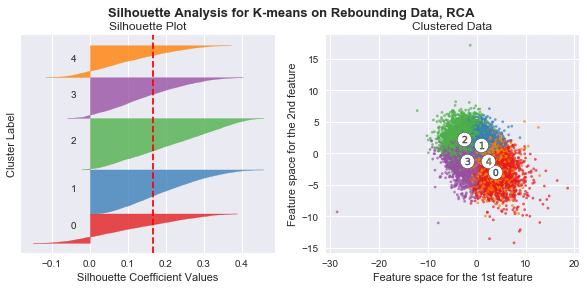

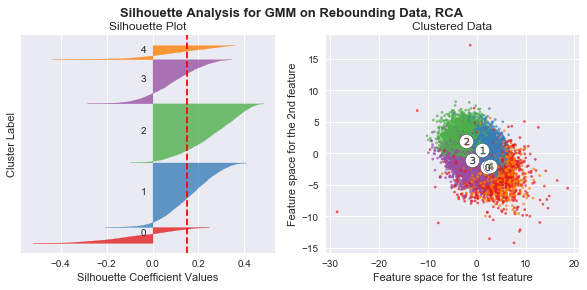

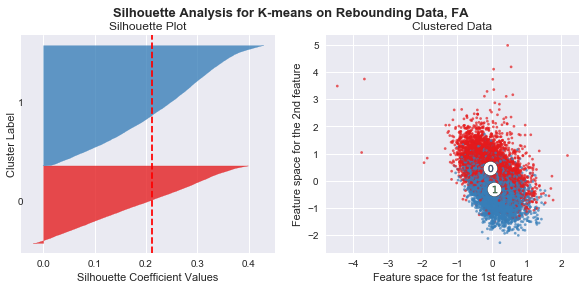

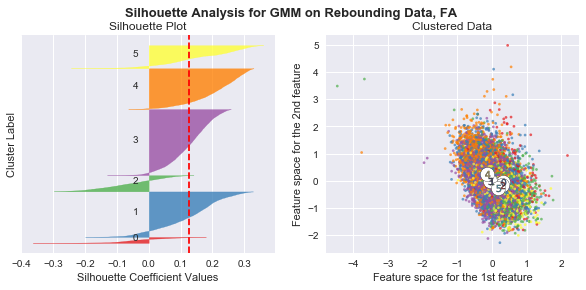

In [71]:
data_reb_dict = {'Rebounding': {'No Transform':[Xreb_norm, 8, 8],
                                'PCA':[rebpca.values[:,:17], 2, 7],
                                'ICA':[rebica.values, 7, 6],
                                'RCA':[rebrca.values, 5, 5],
                                'FA':[rebfa.values, 2, 6]
                           }
            }

for side, dict1 in data_reb_dict.items():
    for transform, d in dict1.items():
        print(transform + ' 1')
        silhouette(d[1], d[0],
                   'Silhouette Analysis for K-means on {0} Data, {1}'.format(side, transform),
                   'Kmeans')
        print(transform + ' 2')
        silhouette(d[2], d[0],
                   'Silhouette Analysis for GMM on {0} Data, {1}'.format(side, transform),
                   'GMM')